# **Traj Projections at Elevation Part 3**
Author: Declan Costello

Date: 8/6/2023

## **Part 3 Description**

Here I clean the data with imputation 

start predicting batted balls trajectory distance based on 
- LA
- EV
- Spray      (Feature engineering)
- Barrel     (Feature engineering)
- Pitch Type (Feature engineering)

realize batter cant control pitch type, but grouping pitch types to see trajs off difff pitch breaks could be helpful

## **Table of Context**

1. [Installation](#Installation)
2. [Inspecting Data](#Inspecting-Data)
3. [Cleaning Data w/ cd](#Cleaning-Data)
5. [Exploring Cleaned Data w/ cd](#Exploring-Cleaned-Data)
4. [Machine Learning](#Machine-Learning)
5. [Results](#Results)
6. [Future Analysis](#Future-Analysis)

# **Installation**

The following installs the necessary packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler


## **Inspecting Data**

In [2]:
data = pd.read_csv('pybaseball_2022.csv')
data = data[data['hit_distance_sc'].notna()]

In [3]:
data = data[data['events'].isin(["field_out", "single", "double",  "triple", "home_run"])]

data = data[['hit_distance_sc','launch_angle','launch_speed', "hc_x", "hc_y", "release_speed", "events", "home_team", "pitch_type", "stand", "p_throws"]]

In [4]:
print(data.shape)

data.isnull().sum().sort_values(ascending=False)

(116316, 11)


launch_speed       112
hc_x                38
hc_y                38
release_speed        7
launch_angle         2
hit_distance_sc      0
events               0
home_team            0
pitch_type           0
stand                0
p_throws             0
dtype: int64

**CD**

# not pos w hitting, have to transfer for a pitching project :(

CD --> 'gamedate'+'hometeam' --> zip code --> temp, humidity, air pressure --> cd

#'game_date','home_team',

**pull %**

#more helpful w batter hand..... look in vas

**DHHR**

https://blogs.fangraphs.com/now-lets-tweak-hard-hit-rate-using-spray-angle/

## **Cleaning Data**

# IMPUTE AFTER QUICK FEATURE ENGNEERING

In [5]:
#IMPUTE THIS!

data = data[data['hc_x'].notna()]
data = data[data['hc_y'].notna()]
data = data[data['launch_angle'].notna()]
data = data[data['launch_speed'].notna()]
data = data[data['release_speed'].notna()]

# **Feature Engineering**

**Platoon Splits**

 - 0 --> bad batting matchup
 - 1 --> good batting matchup

In [6]:
data['fav_platoon_split_for_batter'] = np.where(data['stand']!= data['p_throws'], 1, 0)


**Pitch Type**

 - 0 --> fastball
 - 1 --> breaking
 - 2 --> offspeed

In [7]:
pitch_type_grouped = {
    'FF':0,
    'SI':0,
    'SL':1,
    'CH':2,
    'FC':0,
    'CU':1,
    'ST':1,
    'KC':1, #knuckle curve a breaking ball, not offspeed right?
    'FS':2,
    'SV':1,
    'FA':0,
    'EP':2,
    'CS':1,#spiked curve?
    'KN':2 #knuckle ball is def off speed right?
}

data['grouped_pitch_type'] = data['pitch_type'].map(pitch_type_grouped)

**Dome**

- 0 --> no roof
- 1 --> roof

In [8]:
Domed_Stadiums = {
    'COL':0,
    'PHI':0,
    'AZ':1,
    'TOR':1,
    'STL':0,
    'NYY':0,
    'CLE':0,
    'KC':0,
    'PIT':0,
    'MIN':0,
    'DET':0,
    'WSH':0,
    'CWS':0,
    'NYM':0,
    'BOS':0,
    'BAL':0,
    'MIA':1,
    'OAK':0,
    'HOU':1,
    'SD':0,
    'LAD':0,
    'TEX':1,
    'SEA':1,
    'LAA':0,
    'CIN':0,
    'CHC':0,
    'TB':1,
    'SF':0,
    'ATL':0,
    'MIL':1
}

data['domed'] = data['home_team'].map(Domed_Stadiums)

**Elevation**

- stadium --> ft in elevation

In [9]:
Stadium_elevation = {
    'COL':5183,
    'PHI':9,
    'AZ':1082,
    'TOR':247,
    'STL':455,
    'NYY':54,
    'CLE':582,
    'KC':750,
    'PIT':743,
    'MIN':812,
    'DET':596,
    'WSH':25,
    'CWS':596,
    'NYM':54,
    'BOS':20,
    'BAL':130,
    'MIA':15,
    'OAK':42,
    'HOU':38,
    'SD':13,
    'LAD':267,
    'TEX':616,
    'SEA':10,
    'LAA':160,
    'CIN':683,
    'CHC':596,
    'TB':44,
    'SF':63,
    'ATL':1050,
    'MIL':593
}

data['game_elevation'] = data['home_team'].map(Stadium_elevation)

 **Barrel**

In [10]:
data["Barrel"] = data["launch_speed"]-data["release_speed"]

#delete release_speed now that Barrel is established
del data['release_speed']

Text(0.5, 1.0, 'launch_speed vs Barrel, looks like its easier to barrel fast balls?, maybe this is obvious?')

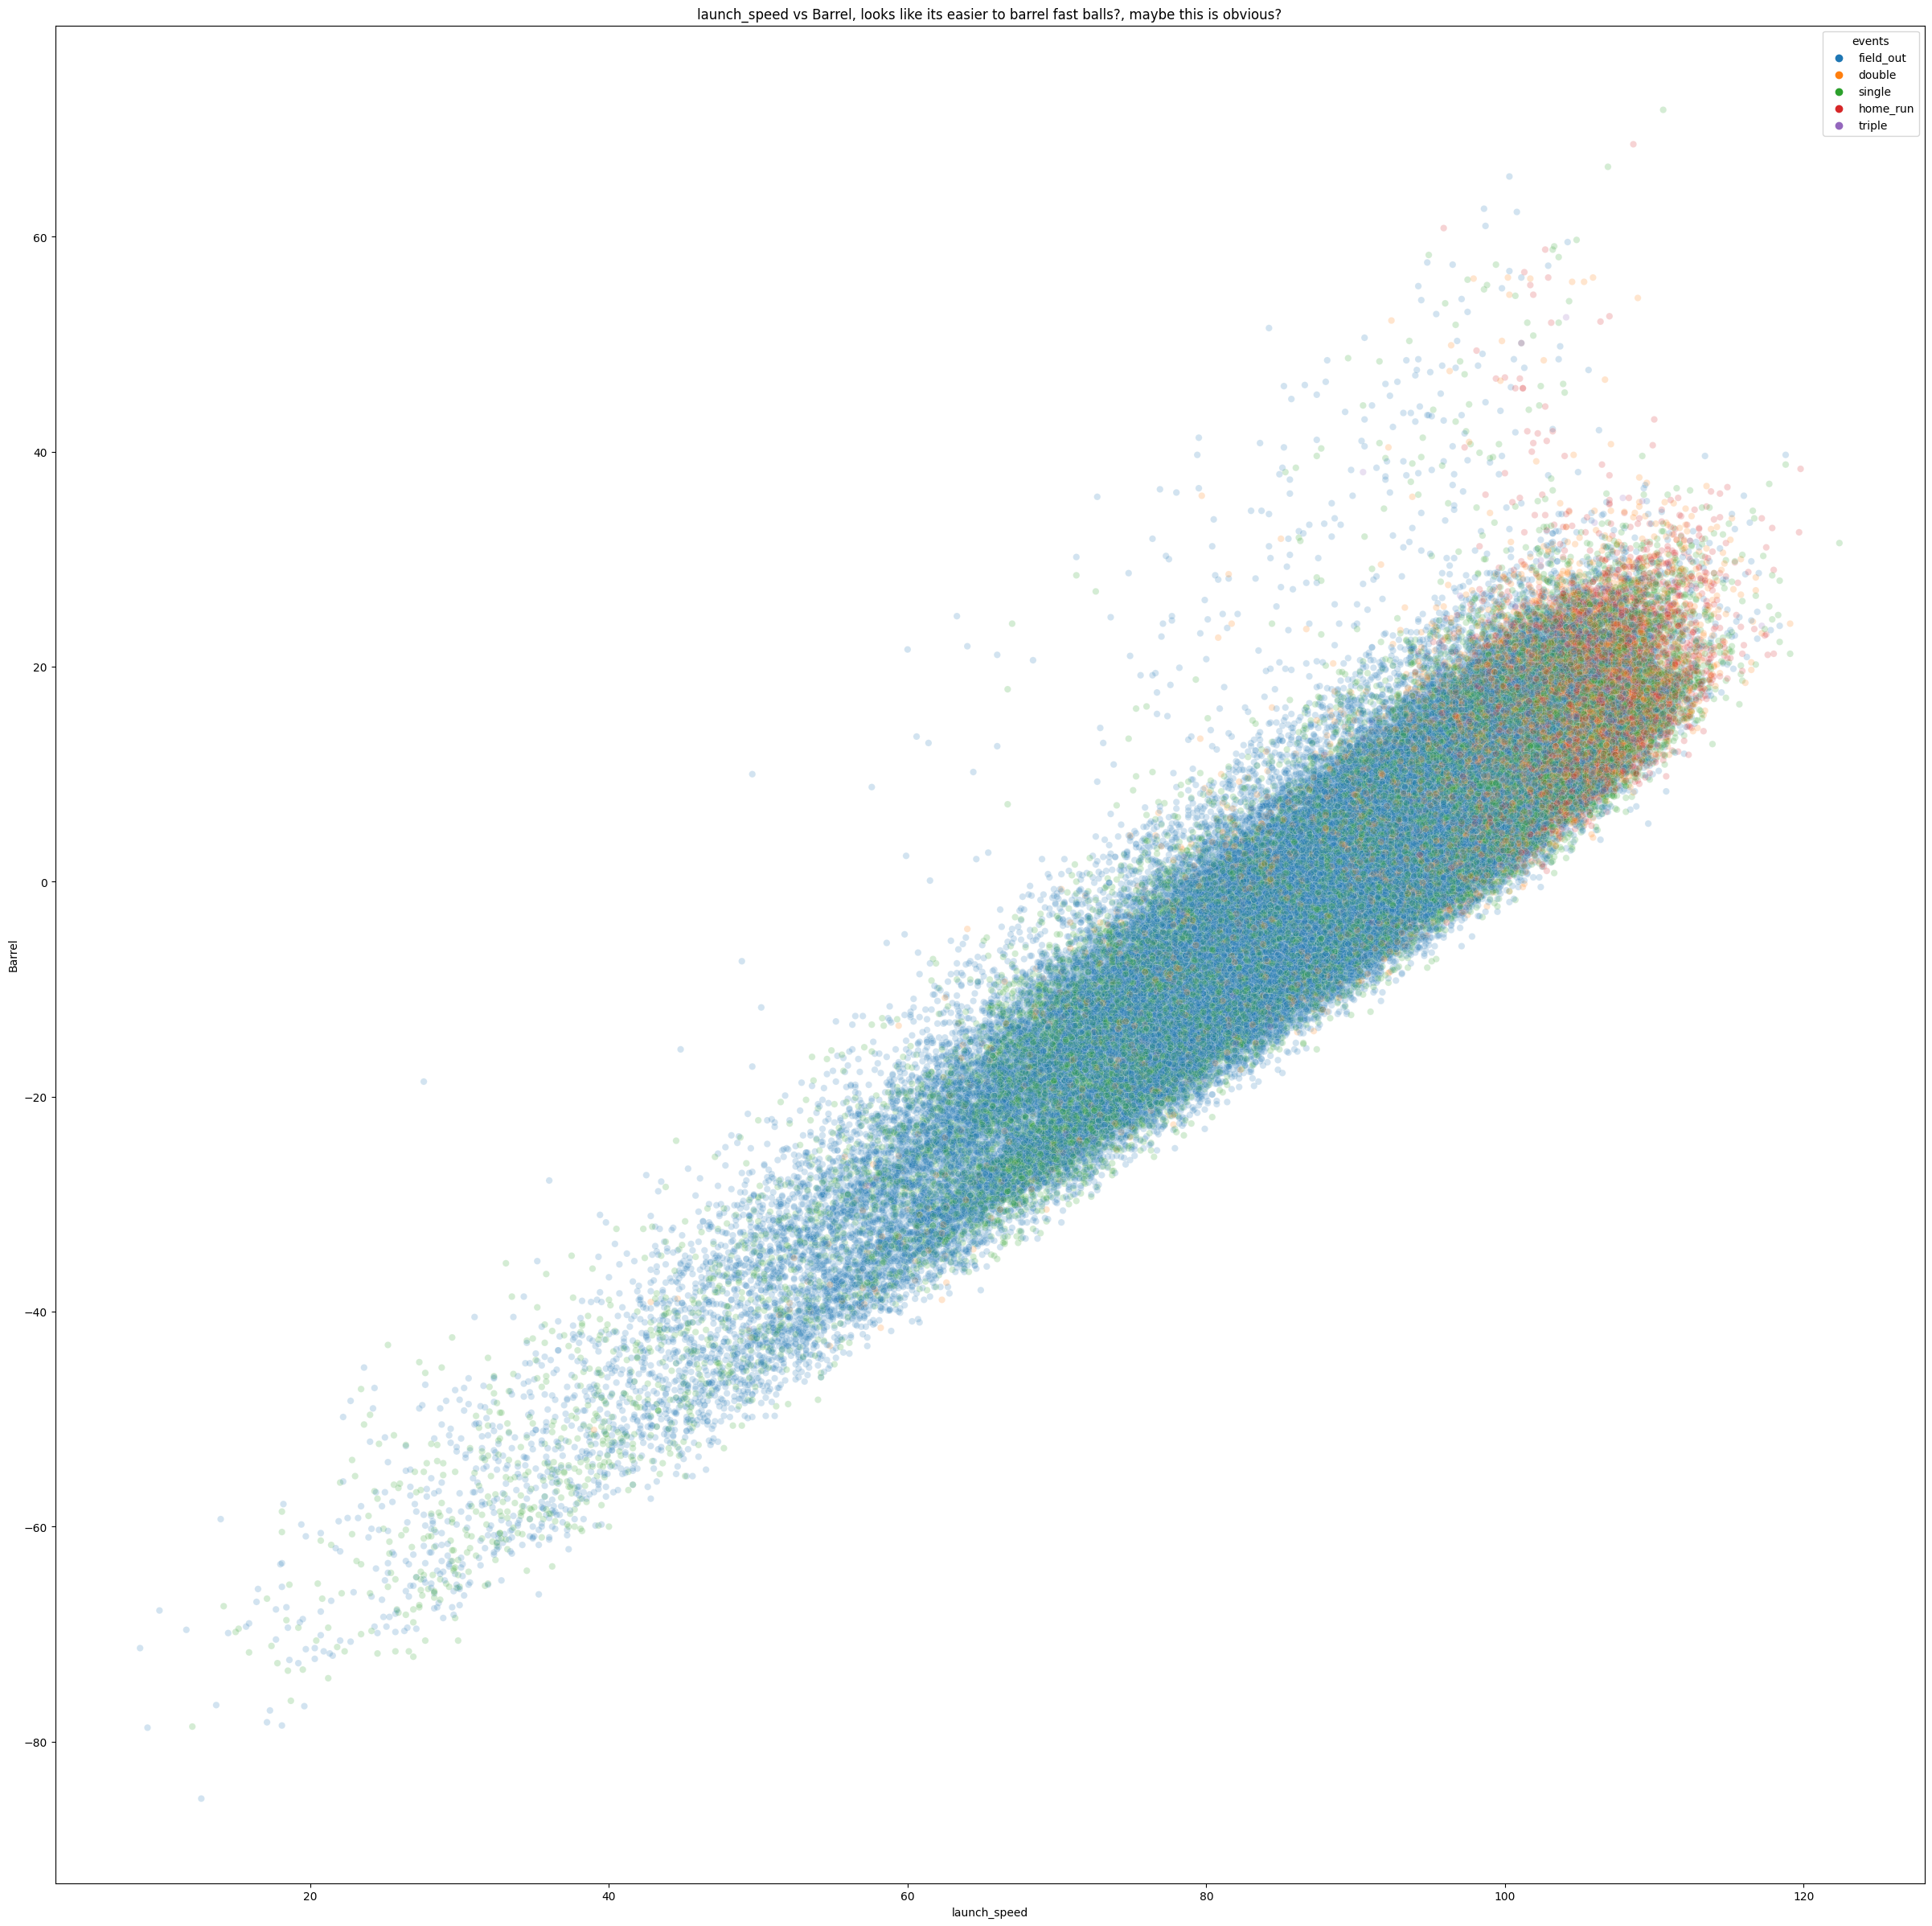

In [11]:
plt.figure(figsize=(30,30))
sns.scatterplot(data = data, x=data.launch_speed, y=data.Barrel,  hue = data.events, alpha = 0.2)
plt.title('launch_speed vs Barrel, looks like its easier to barrel fast balls?, maybe this is obvious?')

 **Spray**

In [12]:
data["spray_angle"] = np.arctan((data["hc_x"]-125.42)/(198.27-data["hc_y"]))*180/np.pi*.75

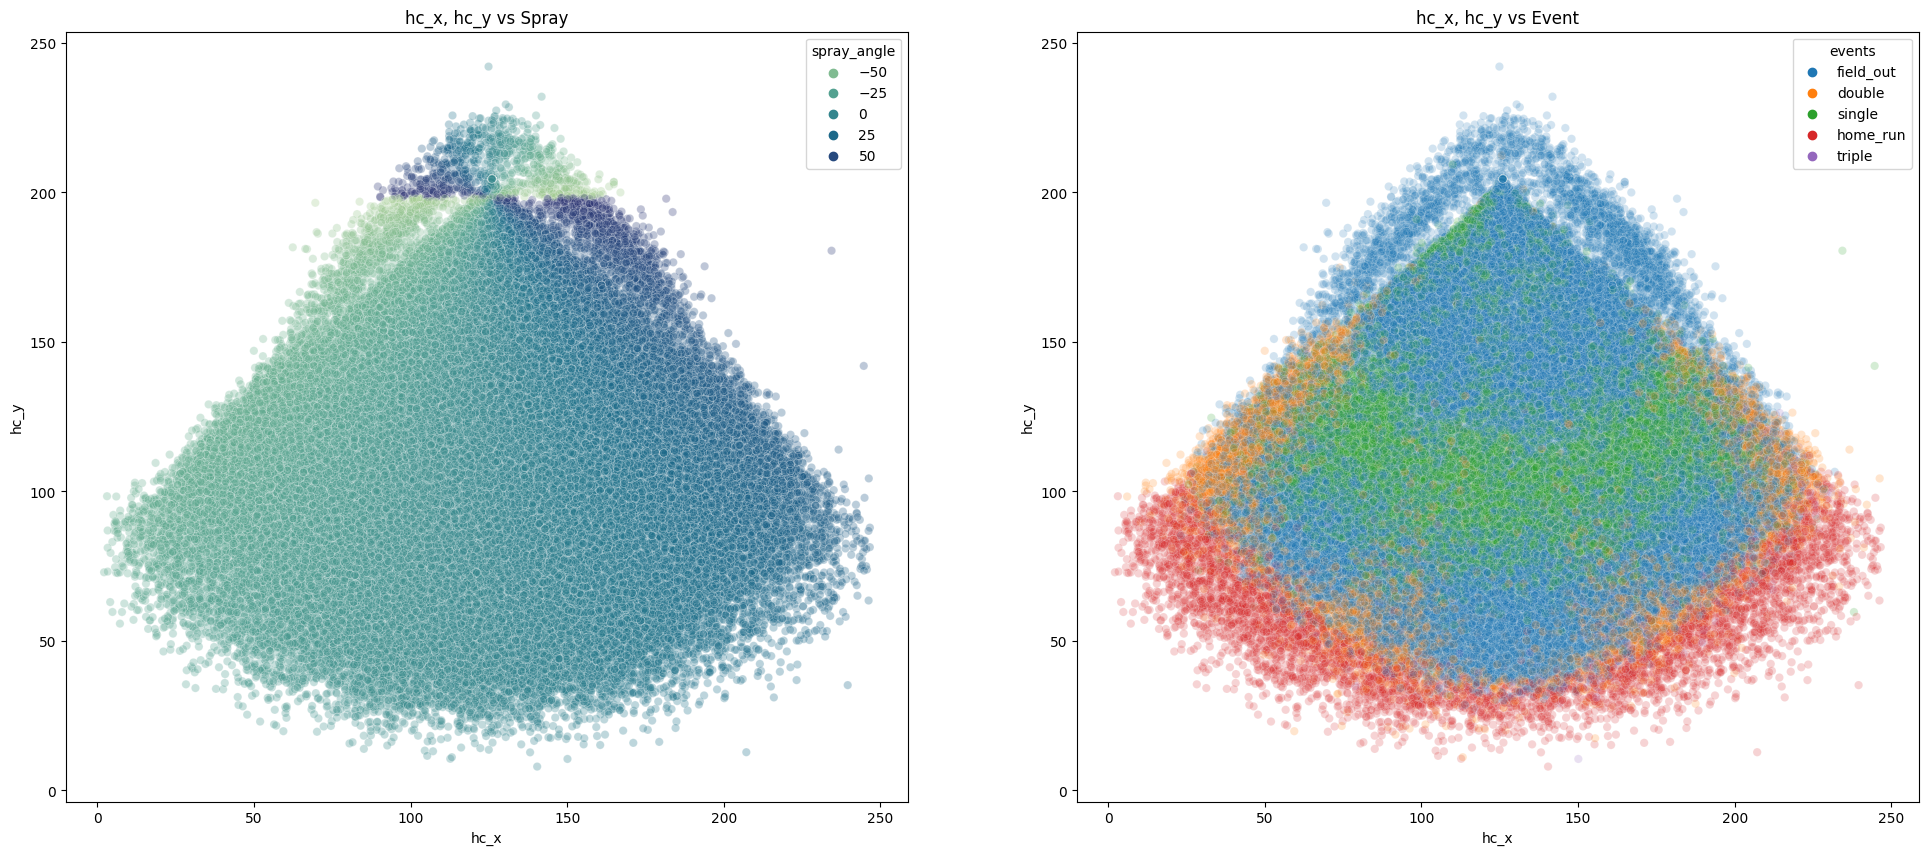

In [13]:
plt.figure(figsize=(50,10))

plt.subplot(141)
sns.scatterplot(data = data, x=data.hc_x, y=data.hc_y, hue = data.spray_angle, alpha = 0.3, palette='crest')
plt.title('hc_x, hc_y vs Spray')

plt.subplot(142)
#cmap="PiYG")
sns.scatterplot(data = data, x=data.hc_x, y=data.hc_y,  hue = data.events, alpha = 0.2)
plt.title('hc_x, hc_y vs Event')

plt.show()

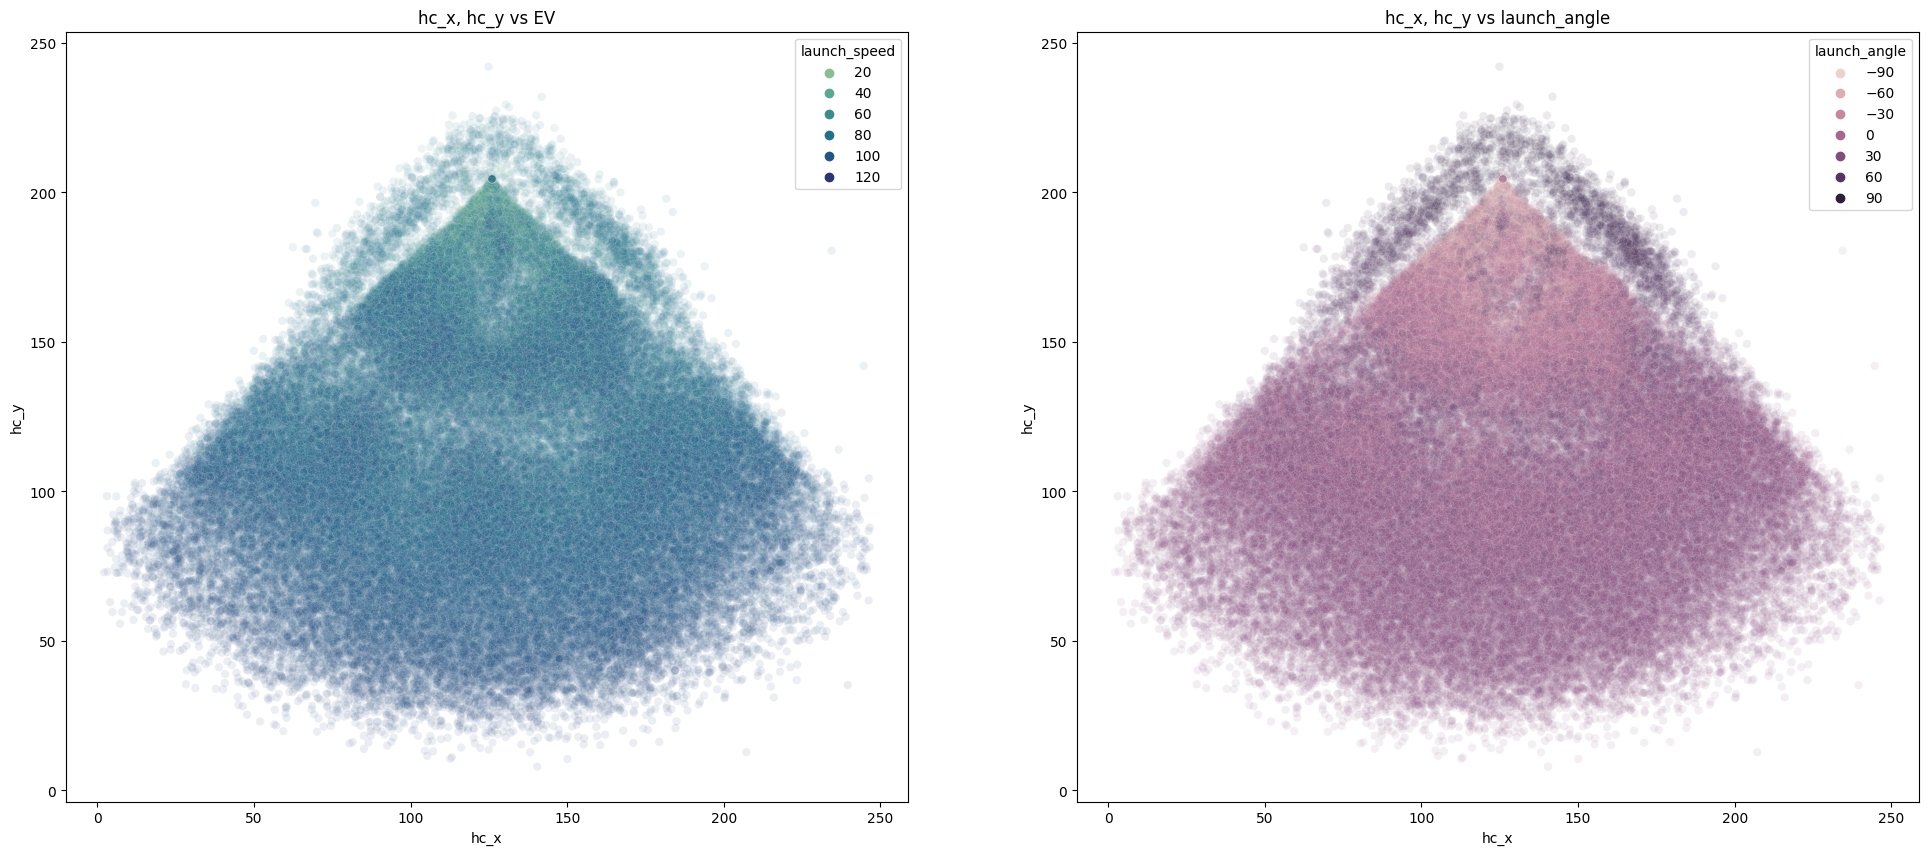

In [14]:
plt.figure(figsize=(50,10))

plt.subplot(141)
sns.scatterplot(data = data, x=data.hc_x, y=data.hc_y, hue = data.launch_speed, alpha = 0.09, palette='crest')
plt.title('hc_x, hc_y vs EV')

plt.subplot(142)
#cmap="PiYG")
sns.scatterplot(data = data, x=data.hc_x, y=data.hc_y,  hue = data.launch_angle, alpha = 0.09)
plt.title('hc_x, hc_y vs launch_angle')

plt.show()

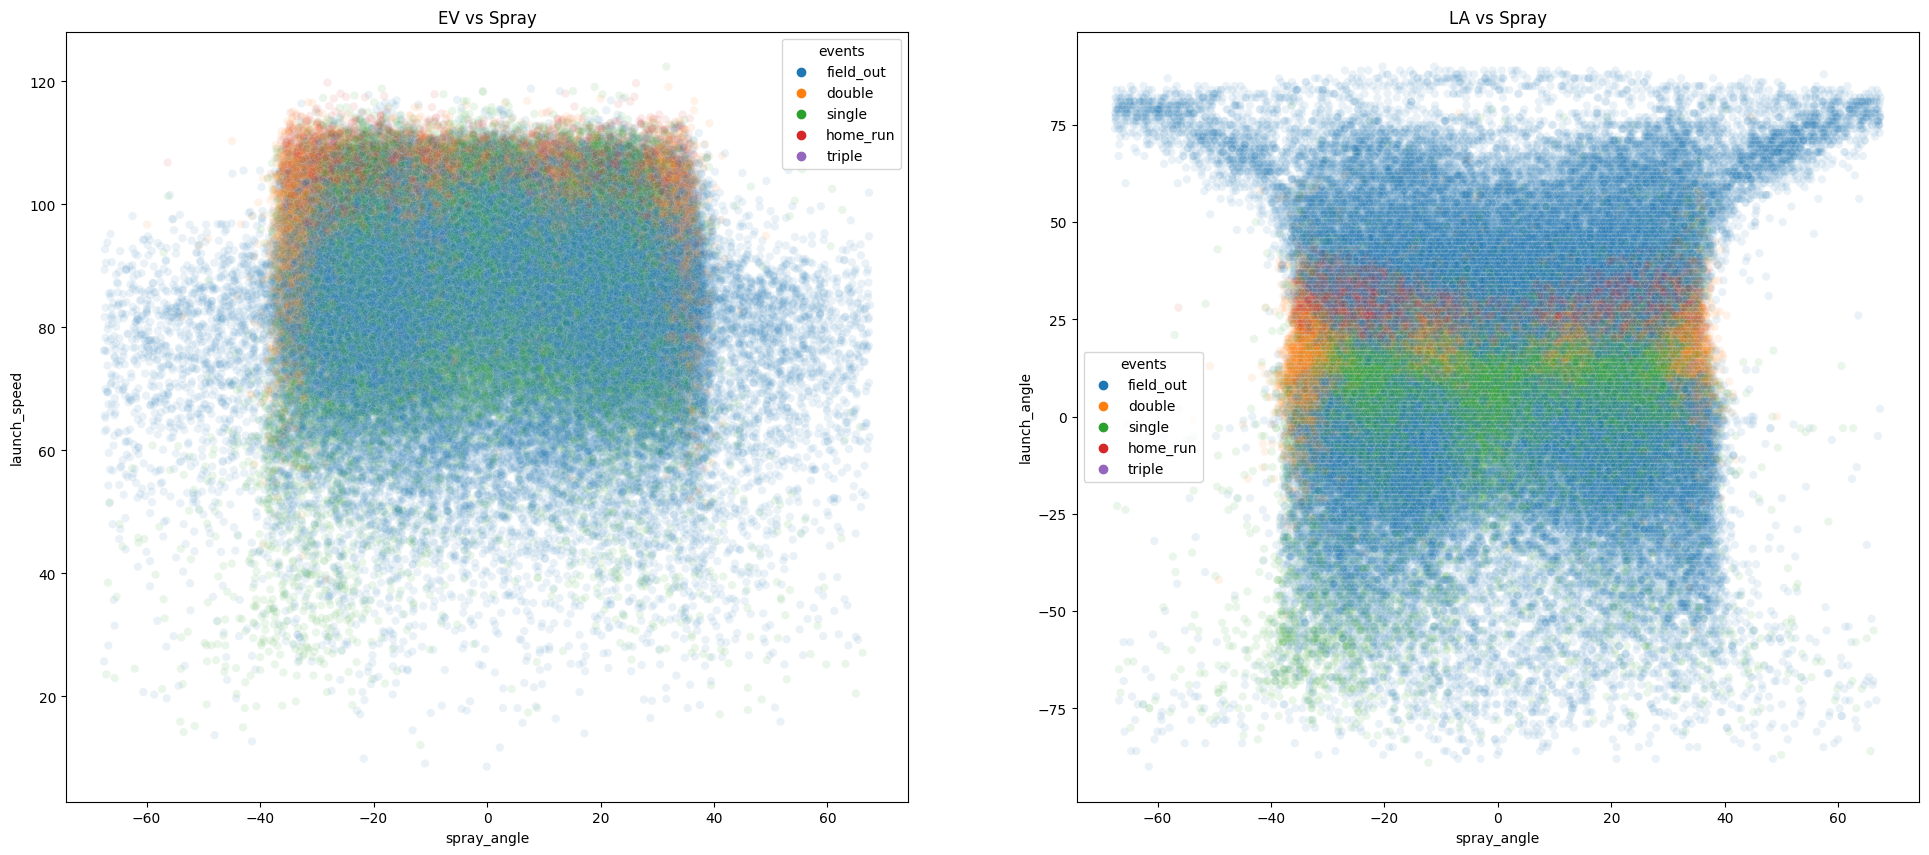

In [15]:
plt.figure(figsize=(50,10))

plt.subplot(141)
sns.scatterplot(data = data, x=data.spray_angle, y=data.launch_speed,  hue = data.events, alpha = 0.09)
plt.title('EV vs Spray')

plt.subplot(142)
#cmap="PiYG")
sns.scatterplot(data = data, x=data.spray_angle, y=data.launch_angle,  hue = data.events, alpha = 0.09)
plt.title('LA vs Spray')

plt.show()

In [16]:
#delete hc_x hc_y now that spray is established
del data["hc_x"]
del data["hc_y"]

**DHHR**

** pull % #more helpful w batter hand..... **


# **Train Test Split**

In [17]:
feature_cols = ['launch_angle', 'launch_speed', 'spray_angle', 'Barrel', 'domed', 'game_elevation', 'grouped_pitch_type', 'fav_platoon_split_for_batter']
#incudle "stand", "p_throws" but one hot encode them....
X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0) # THIS ONE PREDICTS DISTANCE... STILL SWP NAMES?#

# **Random Forest Regressor**

In [18]:
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

score_dataset(X_train, X_valid, y_train, y_valid)

/var/folders/vc/prq7ffv51gl630xh6bmjgj700000gp/T/ipykernel_21085/1614683412.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


9.402773329889806

# **Random Forest Regressor StandardScaler**

In [19]:
def score_dataset_2(X_train, X_valid, y_train, y_valid):
    pipeline = Pipeline([
    ("Standard Scaling", StandardScaler()), #try minmax scaler later
    ("Linear Regression", RandomForestRegressor())
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

score_dataset_2(X_train, X_valid, y_train, y_valid)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


9.397732007575758

# **Random Forest Regressor MinMaxScaler**

In [20]:
def score_dataset_2(X_train, X_valid, y_train, y_valid):
    pipeline = Pipeline([
    ("MinMax Scaling", MinMaxScaler()), #try minmax scaler later
    ("Linear Regression", RandomForestRegressor())
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

score_dataset_2(X_train, X_valid, y_train, y_valid)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


9.391047262396695

# **Hyper Parameter Tune**

grid search, bayesian, gradient descent

# **Results**

In [21]:
# results_df = pd.DataFrame(columns=['Model','Mean Squared Error','Mean Absolute Error','Model Score'])

# results_df.loc[0] = ['Linear Regression',LinearRegression_mean_squared_error,LinearRegression_mean_absolute_error,LinearRegression_model_score]

# results_df.loc[1] = ['Random Forest Regressor', RandomForestRegressor_mean_squared_error, RandomForestRegressor_mean_absolute_error, RandomForestRegressor_model_score]  # adding a row

# results_df

In [22]:
# #only turning off for graph
# import warnings
# warnings.filterwarnings("ignore")

# plt.figure(figsize=(50,5))

# fig, axes = plt.subplots(1, 3, figsize=(35, 7))

# plt.subplot(141)
# sns.barplot(data=results_df, x="Model", y="Mean Squared Error", palette='viridis')
# plt.title('Mean Squared Error')

# plt.subplot(142)
# sns.barplot(data=results_df, x="Model", y="Mean Absolute Error", palette='viridis')
# plt.title('Mean Absolute Error')

# plt.subplot(143)
# sns.barplot(data=results_df, x="Model", y="Model Score", palette='viridis')
# plt.title('Model Score')

# plt.show()

**f1 scores**